# 01 — EDA: Working Capital & CCC Diagnostics

This notebook explores synthetic operating data to:
- Compute **DSO, DPO, DIO, and CCC**
- Visualize **trends and seasonality**
- Quantify **cash unlock** from targeted improvements
- Build a **waterfall bridge** from current → target CCC

> All data are synthetic; methods are client-ready.

In [6]:
# Easy fix for finding parent directory modules
import sys, os
sys.path.append(os.path.abspath(".."))

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from value_ops_lab.synth import make_synthetic
from value_ops_lab.ccc import dso, dpo, dio, ccc, cash_unlocked
from value_ops_lab.diagnostics import waterfall_ccc_impacts

plt.rcParams["figure.figsize"] = (8,4)
np.set_printoptions(suppress=True, linewidth=120)

# Generate synthetic operating panel
n_months = 36
df = make_synthetic(n_months)
df["month"] = pd.to_datetime(df["month"])

df.tail(3)

,month,sales,cogs,ar_balance,ap_balance,inventory
33,2025-10-01,50000.0,26026.788170,10628.169241,2818.234362,4191.148225
34,2025-11-01,50000.0,33234.517113,13116.211838,4882.796742,7230.264135
35,2025-12-01,50000.0,20037.901079,13979.039874,1419.092355,3939.999346


## Input signals
- **Sales / COGS**: revenue & cost structure
- **AR / AP / Inventory** balances
- We use end-of-month balances & monthly flows to estimate WC days.

In [8]:
sales_df = df[["month", "sales"]]
cogs_df  = df[["month", "cogs"]]

dso_df = dso(df[["month", "ar_balance"]], sales_df)
dpo_df = dpo(df[["month", "ap_balance"]], cogs_df)
dio_df = dio(df[["month", "inventory"]], cogs_df)
ccc_df = ccc(dso_df, dpo_df, dio_df)

ccc_df.tail(6)

,month,DSO,DPO,DIO,CCC
30,2025-07-01,94.842756,51.366702,49.545642,93.021697
31,2025-08-01,140.410170,34.824483,48.151087,153.736773
32,2025-09-01,73.035262,89.048005,114.695458,98.682715
33,2025-10-01,77.585635,39.522954,58.776715,96.839396
34,2025-11-01,95.748346,53.625597,79.406793,121.529542
35,2025-12-01,102.046991,25.849449,71.768982,147.966524


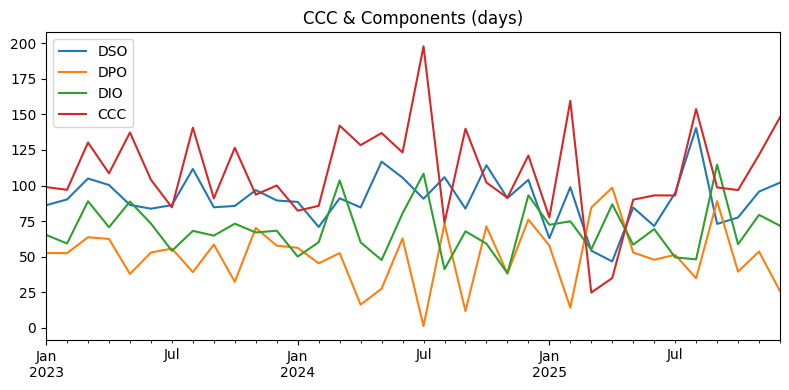

In [9]:
ax = ccc_df.plot(x="month", y=["DSO","DPO","DIO","CCC"], title="CCC & Components (days)")
ax.set_xlabel("")
plt.tight_layout(); plt.show()

,sales,cogs
month,,
1,76199.863647,44935.162374
2,71988.380266,47228.859555
3,69965.782414,42489.348932
4,68663.858118,37034.672572
5,57870.501410,34065.098805
6,51259.524377,31496.173602
7,51660.481728,30137.832237
8,60595.250032,39530.937527
9,57313.873241,34336.287793


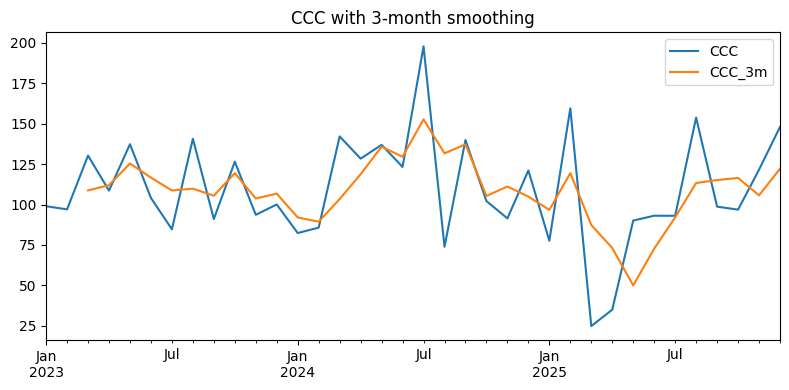

In [10]:
df["month_num"] = df["month"].dt.month
seasonality = df.groupby("month_num")[["sales","cogs"]].mean().rename_axis("month")
display(seasonality)

ccc_df["CCC_3m"] = ccc_df["CCC"].rolling(3).mean()
ax = ccc_df.plot(x="month", y=["CCC","CCC_3m"], title="CCC with 3-month smoothing")
ax.set_xlabel("")
plt.tight_layout(); plt.show()

## What-if: Cash Unlock from Operational Targets
We simulate targeted improvements (days):
- **DSO** ↓ (faster collections)
- **DIO** ↓ (lean inventory)
- **DPO** ↑ (longer payment terms)

We translate new CCC into **cash unlocked** using daily sales.

In [11]:
# Targets (days)
dso_shift = 5
dio_shift = 3
dpo_shift = 4

baseline = ccc_df.iloc[-1]
steps = waterfall_ccc_impacts(
    baseline_row=baseline,
    shifts={"DSO": -dso_shift, "DIO": -dio_shift, "DPO": +dpo_shift},
)
display(steps)

daily_sales = sales_df["sales"].iloc[-1] / 30.0
current_ccc = float(baseline["CCC"])
target_ccc  = float(steps["new_CCC"].iloc[-1])
unlocked = cash_unlocked(current_ccc, target_ccc, daily_sales)
print(f"Estimated cash unlocked: ${unlocked:,.0f}")

,lever,delta_days,new_CCC
0,DSO,5,142.966524
1,DIO,3,139.966524
2,DPO,4,135.966524


Estimated cash unlocked: $20,000


In [ ]:
# Cash Unlock Waterfall (ΔCCC × Daily Sales) — using lever/new_CCC columns

labels = steps["lever"].tolist()

# Compute per-step ΔCCC (signed):
# start with baseline CCC, then each new_CCC; take diffs
ccc_baseline = float(ccc_df.iloc[-1]["CCC"])
ccc_path = np.r_[ccc_baseline, steps["new_CCC"].to_numpy()]
delta_ccc_per_step = np.diff(ccc_path)  # size = len(steps); usually negative (improvement)

# Convert days to cash: negative ΔCCC => positive cash unlocked
cash_impacts = -delta_ccc_per_step * daily_sales

# Build running totals for stacked bars
running = np.cumsum(cash_impacts)
base = np.r_[0, running[:-1]]

# Plot
plt.figure(figsize=(9,4))
for i, (b, h) in enumerate(zip(base, cash_impacts)):
    color = "#2ca02c" if h >= 0 else "#d62728"  # green = unlock, red = drain
    plt.bar(i, h, bottom=b, width=0.6, color=color)

plt.xticks(range(len(labels)), labels, rotation=0)
plt.title("Cash Unlock Waterfall (ΔCCC × Daily Sales)")
plt.ylabel("Cash Impact ($)")
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

# Nice: show a small reconciliation table too
recon = pd.DataFrame({
    "lever": labels,
    "ΔCCC_days": delta_ccc_per_step.round(2),
    "cash_impact_$": cash_impacts.round(0).astype(int),
    "new_CCC": steps["new_CCC"].round(2),
})
recon

Index(['lever', 'delta_days', 'new_CCC'], dtype='object')
  lever  delta_days     new_CCC
0   DSO           5  142.966524
1   DIO           3  139.966524
2   DPO           4  135.966524
